In [ ]:
!huggingface-cli login
# --token XXX --add-to-git-credential --n


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `LLM` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `LLM`


This notebook contains several modular classes designed to handle tasks like data processing, evaluation, and model interaction in a contest evaluation pipeline.

1. **DriveManager**: Manages Google Drive operations in a Colab environment, such as mounting and accessing paths.
2. **ModelLoader**: Loads and configures Hugging Face models and tokenizers, providing methods for text generation.
3. **DataCleaner**: Provides utilities for cleaning text, calculating token sizes, and processing model outputs.
4. **Summarizer**: Generates concise summaries of contest descriptions using a language model.
5. **SubmissionEvaluator**: Evaluates individual submissions by preparing a prompt with few-shot examples and querying the model.
6. **DiscriminativeEvaluator**: Provides numeric-based evaluations for submissions, categorizing them as Excellent, Average, or Poor.
7. **ContestEvaluator**: Orchestrates the evaluation of all submissions in a contest and optionally saves the results to a CSV.

Each class is modular and designed for reusability and scalability, allowing easy customization and integration with new datasets or models.


In [ ]:
# @title Imports
import os
import re
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria
from google.colab import files
import matplotlib.pyplot as plt
from accelerate import infer_auto_device_map

In [ ]:
# @title DriveManager, ModelLoader, DataCleaner

# --------------------------------------------------
# DriveManager
# --------------------------------------------------
class DriveManager:
    """
    Class Name: DriveManager

    Purpose:
        - Handle mounting Google Drive in a Colab environment.
        - Provide convenient path handling if needed.

    Responsibilities:
        - Mount/unmount Google Drive.
        - Potentially provide standard path resolutions for loading/saving.

    Example Usage:
        drive_mgr = DriveManager()
        drive_mgr.mount_drive()
    """

    def __init__(self, mount_path="/content/drive/"):
        """
        Constructor for DriveManager.

        Args:
            mount_path (str): The path at which to mount Google Drive.

        Attributes:
            mount_path (str): Where Google Drive is mounted in Colab.
        """
        self.mount_path = mount_path

    def mount_drive(self, force_remount=True):
        """
        Mounts Google Drive using the provided mount path.

        Args:
            force_remount (bool): Whether to force-remount if already mounted.
        """
        from google.colab import drive
        drive.mount(self.mount_path, force_remount=force_remount)


# --------------------------------------------------
# ModelLoader
# --------------------------------------------------
class ModelLoader:
    """
    Class Name: ModelLoader

    Purpose:
        - Load and configure a Hugging Face model and tokenizer.
        - Provide a convenient method for text generation.

    Responsibilities:
        - Download/load a tokenizer and model from a given model name.
        - Handle device placement (CPU/GPU) and half-precision casting if desired.
        - Provide a generate_text() method for inference.

    Example Usage:
        model_loader = ModelLoader("meta-llama/Llama-3.1-8B-Instruct")
        model_loader.load_model_and_tokenizer()
        response = model_loader.generate_text(prompt, max_length=200)
    """

    def __init__(self, model_name, device=None):
        """
        Constructor for ModelLoader.

        Args:
            model_name (str): The name or path of the model on Hugging Face.
            device (str, optional): The device to load model onto (e.g., "cuda" or "cpu").
                                    Defaults to "cuda" if available, else "cpu".

        Attributes:
            model_name (str): The Hugging Face model name.
            tokenizer (AutoTokenizer): The loaded tokenizer (populated after load_model_and_tokenizer()).
            model (AutoModelForCausalLM): The loaded model (populated after load_model_and_tokenizer()).
            device (str): The device for model inference.
        """
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

    def load_model_and_tokenizer(self):
        """
        Loads the tokenizer and model from Hugging Face.
        Casts the model to half-precision if the device is GPU.
        """
        print(f"Loading model: {self.model_name} on device {self.device}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            device_map="auto", # if self.device == "cuda" else None,
            torch_dtype=torch.float16 # if self.device == "cuda" else torch.float32
        ).to(self.device)

    def generate_text(self, prompt, max_length=512, temperature=0.7, stop_token_ids=None):
        """
        Generates text using the loaded model.

        Args:
            prompt (str): The input text/prompt for generation.
            max_length (int): Maximum number of tokens for the output.
            temperature (float): Sampling temperature.

        Returns:
            str: The generated text from the model.
        """
        if self.tokenizer is None or self.model is None:
            raise ValueError("Tokenizer/Model not loaded. Call load_model_and_tokenizer() first.")

        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        outputs = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            temperature=temperature,
            attention_mask=inputs["attention_mask"],
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=False)


# --------------------------------------------------
# DataCleaner
# --------------------------------------------------
class DataCleaner:
    """
    Class Name: DataCleaner

    Purpose:
        - Provide static methods to clean text and calculate token sizes.

    Responsibilities:
        - Clean text by removing special characters (except dots).
        - Calculate the number of tokens of a given text using a tokenizer.
    """

    @staticmethod
    def clean_text(text):
        """
        Clean a text field by removing unnecessary symbols (except dots),
        handling newlines, etc.

        Args:
            text (str): Input text to clean.

        Returns:
            str: Cleaned text or an empty string if invalid/empty.
        """
        if not isinstance(text, str) or not text.strip():
            return ""

        # Remove weird signs except for dots
        cleaned = re.sub(r'[^\w\s.]', '', text)
        # Replace multiple newlines with space
        cleaned = re.sub(r'\n+', ' ', cleaned)
        return cleaned.strip()

    @staticmethod
    def calculate_token_size(text, tokenizer):
        """
        Calculate the number of tokens in a given text using the tokenizer.

        Args:
            text (str): The input text.
            tokenizer: The tokenizer from Hugging Face.

        Returns:
            int: Number of tokens.
        """
        tokens = tokenizer(text, return_tensors="pt")["input_ids"]
        return tokens.shape[1]

    @staticmethod
    def strip_prompt_and_eos_token(response, prompt, tokenizer):
        """
        Strips the prompt from the response and removes the EOS token if it exists.

        Args:
            response (str): The generated text response from the model.
            prompt (str): The input prompt used for the model.
            tokenizer: The tokenizer used by the model, providing the EOS token.

        Returns:
            str: The cleaned response text.
        """
        # Strip the prompt from the response
        response_start = response.find(prompt[-100:])
        if response_start != -1:
            response = response[response_start + 100:].strip()

        # Check if the response ends with the EOS token and remove it
        eos_token = tokenizer.eos_token  # e.g., "<|eot_id|>"
        if response.endswith(eos_token):
            response = response[: -len(eos_token)].strip()

        return response

In [ ]:
# @title DiscriminativeEvaluator

# --------------------------------------------------
# DiscriminativeEvaluator
# --------------------------------------------------
class DiscriminativeEvaluator:
    """
    Class to evaluate submissions based on quantitative features and generate textual feedback.
    """

    CATEGORY_EXCELLENT = 3
    CATEGORY_AVERAGE   = 2
    CATEGORY_POOR      = 1

    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame containing all submissions.
            top_percentile (float): Percentile threshold for determining Excellent category.
            average_percentile (float): Percentile threshold for determining Average category.
        """
        self.df = df
        self.top_percentile = 0.8
        self.average_percentile = 0.4


        # Simple synonyms for the 3 categories to add mild variation
        self.category_synonyms = {
            self.CATEGORY_EXCELLENT: ["excellent"], # "outstanding"
            self.CATEGORY_AVERAGE:   ["average"], # "moderate"
            self.CATEGORY_POOR:      ["poor"] # "weak"
        }

    def _choose_random_synonym(self, category):
        """Randomly pick a synonym for the given category."""
        return random.choice(self.category_synonyms[category])

    def evaluate_label_category(self, submission_row, same_contest_df, label):
        """
        Evaluate the given label for a submission and categorize it as 'Excellent', 'Average', or 'Poor'.

        Args:
            submission_row (pd.Series): Row of the submission to evaluate.
            same_contest_df (pd.DataFrame): Filtered DataFrame with the same contest.
            label (str): Label to evaluate (e.g., 'submission_word_count', 'num_image').

        Returns:
            int: The category (3 for Excellent, 2 for Average, 1 for Poor).
        """
        label_series = same_contest_df[label].dropna()
        submission_value = submission_row[label]

        # Handle edge case for low averages
        if label_series.mean() < 1 and submission_value == 0:
            return self.CATEGORY_AVERAGE

        # Determine percentile rank
        rank_percentile = label_series.rank(pct=True)[submission_row.name]

        if rank_percentile >= self.top_percentile:
            return self.CATEGORY_EXCELLENT
        elif rank_percentile >= self.average_percentile:
            return self.CATEGORY_AVERAGE
        else:
            return self.CATEGORY_POOR

    def calculate_percentile(self, submission_row, same_contest_df, label):
        """
        Calculate the percentile of a submission's value for a given label.
        """
        label_series = same_contest_df[label].dropna()

        # Handle case with many zeroes
        if label_series.mean() <= 0.5 and submission_row[label] == 0:
            return 0.5  # Treat as average if the mean is very low

        return label_series.rank(pct=True)[submission_row.name]

    def discriminative_evaluation(self, submission_url):
        """
        Perform a discriminative evaluation and return both textual feedback and a string classification.

        Returns:
            tuple: (evaluation_text, disc_classification_str)
                  where disc_classification_str ∈ {"Excellent", "Average", "Poor"}
        """
        try:
            submission_row = self.df[self.df["submission_url"] == submission_url].iloc[0]
        except IndexError:
            raise ValueError(f"Submission URL {submission_url} not found in the dataset.")

        # Filter for the same contest
        contest_name = submission_row["contest_name"]
        same_contest_df = self.df[self.df["contest_name"] == contest_name]

        # Determine overall category based on rank
        rank = submission_row['qs_rank']
        num_submissions = submission_row['num_of_submissions']
        # Higher percentiles = better rankings
        rank_percentile = (num_submissions - rank) / num_submissions

        if rank_percentile >= self.top_percentile:  # High percentile = Excellent
            overall_category = self.CATEGORY_EXCELLENT
        elif rank_percentile >= self.average_percentile:  # Mid percentile = Average
            overall_category = self.CATEGORY_AVERAGE
        else:
            overall_category = self.CATEGORY_POOR  # Low percentile = Poor


        # --- Paragraph 1: Description ---
        desc_value = submission_row["submission_word_count"]
        desc_cat = self.evaluate_label_category(submission_row, same_contest_df, "submission_word_count")
        desc_syn = self._choose_random_synonym(desc_cat)

        if desc_value < 50:
            description_paragraph = (
                "The submission's description contains minimal content, making a proper evaluation difficult. "
                "It falls short of providing key details that could help understand the project effectively."
            )
            alignment_text = ""
        else:
            if desc_cat == self.CATEGORY_EXCELLENT:
                description_paragraph = (
                f"The submission’s description is {desc_syn} compared to other entries. "
                "It contains an extensive amount of text that thoroughly explains the project, covering all essential aspects in detail. "
                "This level of textual detail exceeds that of most other submissions."
                )
                if desc_cat == overall_category:
                    alignment_text = (
                        "The length and level of detail in the description reflect the overall excellent efforts of the submission, "
                        "mirroring the high standards seen throughout the project."
                    )
                elif desc_cat > overall_category:
                    alignment_text = (
                        "The description stands out with superior detail compared to the overall submission quality, "
                        "indicating that the textual documentation may have been prioritized."
                    )

            elif desc_cat == self.CATEGORY_AVERAGE:
                description_paragraph = (
                f"The project’s description is {desc_syn} and offers a moderate amount of text that covers the key points of the project. "
                "It provides a level of detail that is comparable to the average submission."
                )
                if desc_cat == overall_category:
                    alignment_text = (
                        "The description's moderate level of detail is consistent with the overall average quality of submissions, "
                        "providing an amount of text that aligns with what is typically seen in similar entries."
                    )
                elif desc_cat < overall_category:
                    alignment_text = (
                        "Although the overall submission is deemed excellent, the description offers only an average level of detail, "
                        "suggesting that additional elaboration could have further strengthened its documentation compared to other high-quality entries."
                    )
                else:
                    alignment_text = (
                        "The description stands out with more text and detail than what is generally seen in submissions with overall poor quality, "
                        "indicating that extra effort was put into documenting the project relative to its peers."
                    )
            else:  # Poor
                description_paragraph = (
                    f"The description is {desc_syn} compared to other entries. "
                    "It contains very little text, providing only a brief overview of the project. "
                    "Compared to most other submissions, it lacks the level of detail needed to fully understand the project’s scope and functionality."
                )
                if desc_cat == overall_category:
                    alignment_text = (
                        "The description's brevity is consistent with the overall poor quality of the submission, "
                        "indicating that minimal documentation effort was put into this project."
                    )
                elif desc_cat < overall_category:
                    alignment_text = (
                        "While the overall submission is evaluated as higher quality, the description remains relatively brief, "
                        "suggesting that additional elaboration could have further strengthened its documentation and better supported the project's overall presentation."
                    )

        # BOM part
        bom_cat = self.evaluate_label_category(submission_row, same_contest_df, "num_things")
        bom_syn = self._choose_random_synonym(bom_cat)

        if bom_cat == self.CATEGORY_EXCELLENT:
            comp_doc = f"The submission features {bom_syn} documentation of the components, providing a detailed and well-organized list of materials used. "
        elif bom_cat == self.CATEGORY_AVERAGE:
            comp_doc = f"The amount of components used in the project is {bom_syn}, aligning with the average level seen in similar submissions. "
        else:
            comp_doc = (
                f"The amount of components is {bom_syn}, indicating either a very basic implementation or potentially missing material details. "
                "This could hinder the ability to replicate or understand the project’s full scope. "
            )

        description_paragraph += f" {alignment_text} {comp_doc}"


        # --- Documentation Paragraph ---

        # Visual Documentation part
        visual_labels = ["num_image", "num_video"]
        percentiles = [self.calculate_percentile(submission_row, same_contest_df, label) for label in visual_labels]
        avg_percentile = sum(percentiles) / len(percentiles)

        if avg_percentile >= self.top_percentile:
            visual_category = self.CATEGORY_EXCELLENT
        elif avg_percentile >= self.average_percentile:
            visual_category = self.CATEGORY_AVERAGE
        else:
            visual_category = self.CATEGORY_POOR

        visual_syn = self._choose_random_synonym(visual_category)
        images_present = submission_row["num_image"] > 0
        videos_present = submission_row["num_video"] > 0
        gifs_present = submission_row["num_gif"] > 0

        present_formats = [fmt for fmt, present in zip(["images", "videos"], [images_present, videos_present]) if present]
        format_text = " and ".join(present_formats) if present_formats else "visual content"

        # Main visual documentation assessment
        if visual_category == self.CATEGORY_EXCELLENT:
            visual_doc = (
                f"This entry provides {visual_syn} visual documentation, utilizing many {format_text}. "
                "The provided media offer a clear representation of the project, making it easier to understand and replicate. "
                "Compared to other submissions, it includes a notably high amount of visual material."
            )
        elif visual_category == self.CATEGORY_AVERAGE:
            visual_doc = (
                f"This entry provides {visual_syn} visual documentation, incorporating a moderate number of {format_text}. "
                "While the visuals contribute to understanding the project, they are not as extensive as in the highest-ranked submissions. "
                "Even though the available visuals aid comprehension, additional supporting media could have further enhanced clarity and engagement."
            )
        else:
            visual_doc = (
                f"This entry provides {visual_syn} visual documentation, with only limited {format_text} available. "
                "Compared to other entries, the visual content is sparse, making it more difficult to grasp the project fully. "
                "A stronger emphasis on visual documentation would have significantly improved the submission’s presentation."
            )

        # Additional checks for missing content
        if gifs_present:
            visual_doc += " Additionally, animated GIFs are included, helping to illustrate certain aspects dynamically. "

        missing_resources = [res for res, present in zip(["images", "videos"], [images_present, videos_present]) if not present]

        if missing_resources:
            conjunction = "However" if visual_category in (self.CATEGORY_EXCELLENT, self.CATEGORY_AVERAGE) else "Also"
            missing_text = f" {conjunction}, it lacks key resources such as {', '.join(missing_resources)}. "

            if "videos" in missing_resources:
                missing_text += (
                    "Without video documentation, understanding how the project operates in real-time is challenging. Including a demonstration video could have showcased key interactions or features more effectively."
                )

            if "images" in missing_resources:
                missing_text += (
                    " Including images would have helped document the project's components and overall design more effectively, "
                    "ensuring that viewers can quickly understand its structure and purpose."
                )

            visual_doc += missing_text


        # Code
        code_provided = (submission_row["code"] == 1)
        link_provided = (submission_row["link"] == 1)

        if code_provided and link_provided:
            code_text = "It fully shares its code and provides a repository link to encourage collaboration."
        elif code_provided and not link_provided:
            code_text = "The submission includes some code but lacks a central repository link."
        else:
            code_text = "Unfortunately, no code is provided, which could leave technical aspects undisclosed."

        code_doc = f"{code_text} These factors influence how easily others can reproduce or build upon the work."

        documentation_paragraph = visual_doc + code_doc

        # # --- Paragraph 3: Overall Recommendation ---
        if overall_category == self.CATEGORY_EXCELLENT:
        #     overall_text = (
        #         "This submission is judged as **Excellent** overall. It demonstrates outstanding documentation and content quantity, "
        #         "indicating a well-prepared and detailed project."
        #     )

        #     # Identify improvement areas
        #     if visual_category == self.CATEGORY_AVERAGE:
        #         overall_text += " While the overall submission is excellent, the visual documentation could be expanded further to better illustrate key aspects."
        #     elif visual_category == self.CATEGORY_POOR:
        #         overall_text += " However, its visual documentation is limited, and incorporating more images or videos would have enhanced clarity and engagement."

        #     if not code_provided or not link_provided:
        #         overall_text += " Despite its strengths, providing a more accessible code repository could improve collaboration and reproducibility."

            disc_classification_str = "Excellent"

        elif overall_category == self.CATEGORY_AVERAGE:
        #     overall_text = (
        #         "This submission is judged as **Average** overall. It provides a moderate level of documentation and content, "
        #         "but there are areas that could be improved to make it stand out more."
        #     )

        #     # Highlight strengths and weaknesses
        #     if desc_cat == self.CATEGORY_EXCELLENT:
        #         overall_text += " The description is particularly strong, offering a detailed explanation of the project."
        #     elif desc_cat == self.CATEGORY_POOR:
        #         overall_text += " The description, however, lacks sufficient detail, making it harder to understand the full scope of the project."

        #     if visual_category == self.CATEGORY_POOR:
        #         overall_text += " Additionally, the visual documentation is weak, limiting the ability to fully grasp the project's details."

        #     if bom_cat == self.CATEGORY_EXCELLENT:
        #         overall_text += " On the positive side, the component documentation is well-structured, aiding replication and understanding."

        #     if not code_provided:
        #         overall_text += " However, no code was shared, which may hinder reproducibility."
        #     elif not link_provided:
        #         overall_text += " While some code is provided, a central repository link would make it easier for others to build upon this work."

            disc_classification_str = "Average"

        else:  # Poor Overall Category
        #     overall_text = (
        #         "This submission is judged as **Poor** overall. The submission lacks sufficient documentation and content, "
        #         "making it difficult to fully understand or replicate."
        #     )

        #     # Identify if there were any positive aspects
        #     if desc_cat == self.CATEGORY_EXCELLENT:
        #         overall_text += " However, the description contains a substantial amount of text compared to other submissions."
        #     elif desc_cat == self.CATEGORY_AVERAGE:
        #         overall_text += " The description is somewhat detailed but could be further improved."

        #     if visual_category == self.CATEGORY_EXCELLENT:
        #         overall_text += " The visual documentation is a strong point, offering a well-presented set of images and videos."
        #     elif visual_category == self.CATEGORY_AVERAGE:
        #         overall_text += " The visual documentation is average, but adding more media could make the project easier to understand."
        #     else:
        #         overall_text += " The lack of visual documentation significantly impacts comprehension."

        #     if bom_cat == self.CATEGORY_EXCELLENT:
        #         overall_text += " Despite its shortcomings, the component documentation is well-structured, making it easier for others to follow."

        #     if code_provided and link_provided:
        #         overall_text += " Although the project is lacking in other areas, providing access to the code is a valuable aspect."
        #     elif code_provided:
        #         overall_text += " While some code is included, a proper repository link would enhance accessibility."
        #     else:
        #         overall_text += " Unfortunately, no code is provided, making it more difficult for others to build upon this work."

            disc_classification_str = "Poor"

        # Final text assembly using list comprehension
        paragraphs = [
            f"**Description and bills of materials:**\n{description_paragraph}",
            f"**Visuals, code and other documentation:**\n{documentation_paragraph}",
            f"**Overall Recommendation:**\n*{disc_classification_str}*"
        ]

        final_text = "\n\n".join([p for p in paragraphs if p])


        return final_text, disc_classification_str





In [ ]:
# @title Summarizer

# --------------------------------------------------
# Summarizer
# --------------------------------------------------
class Summarizer:
    """
    Class Name: Summarizer

    Purpose:
        - Summarize a given contest description using the model.
    """

    def __init__(self, model_loader: ModelLoader, data_cleaner: DataCleaner, df=None,
                 max_allowed_tokens=100000, summary_size=400):
        """
        Args:
            model_loader (ModelLoader): The loaded model/tokenizer wrapper.
            data_cleaner (DataCleaner): Utility class for cleaning text & counting tokens.
            df (pd.DataFrame, optional): DataFrame with contest info.
            max_allowed_tokens (int): Max tokens for prompt+answer.
            summary_size (int): Approx. size for the answer portion.
        """
        self.model_loader = model_loader
        self.data_cleaner = data_cleaner
        self.df = df
        self.max_allowed_tokens = max_allowed_tokens
        self.summary_size = summary_size

    def summarize_contest_description(self, contest_name):
        """
        Summarize the contest description for the given contest_name.

        Returns:
            str: A cleaned summary of the contest description.
        """
        if self.df is None:
            raise ValueError("A DataFrame must be provided to Summarizer to look up submissions.")

        # Grab the relevant row
        try:
            selected_entry = self.df[self.df['contest_name'] == contest_name].iloc[0]
        except IndexError:
            raise ValueError(f"Contest name {contest_name} not found in the dataset.")

        # Clean text
        contest_description = self.data_cleaner.clean_text(selected_entry['overview'])

        prompt = f"""
                  You are an expert at summarizing information for clarity and relevance. Below is a description of a contest.
                  Your task is to summarize it by focusing on:
                  - What is the contest about?
                  - Main goals and challenges described?
                  - Topics or themes participants address?
                  - Overall purpose of the contest?

                  Write the summary as a single, continuous paragraph and leave out irrelevant details (prizes, hardware giveaways, registration, etc.).

                  Contest Description:
                  {contest_description}

                  End the Summary with '<|eot_id|>'.
                  """

        prompt_tokens = self.data_cleaner.calculate_token_size(prompt, self.model_loader.tokenizer)
        total_max_length = prompt_tokens + self.summary_size
        if total_max_length > self.max_allowed_tokens:
            raise ValueError("Contest description + answer size exceed max token limit.")

        raw_text = self.model_loader.generate_text(
            prompt,
            max_length=total_max_length,
            temperature=0.7,
        )
        cleaned_response = self.data_cleaner.strip_prompt_and_eos_token(raw_text, prompt, self.model_loader.tokenizer)
        torch.cuda.empty_cache()
        return cleaned_response

In [ ]:
# @title ContestEvaluator

# --------------------------------------------------
# ContestEvaluator
# --------------------------------------------------
class ContestEvaluator:
    """
    Orchestrates evaluation of all submissions in a given contest.
    Saves results with extra columns: "contest_description", "discriminative",
    "disc_classification", "generative", "gen_classification", ...
    """

    def __init__(self, submission_evaluator, discriminative_evaluator, summarizer):
        """
        Args:
            submission_evaluator: Evaluates single submissions (generative).
            discriminative_evaluator: Numeric-based evaluation text + classification.
            summarizer: Summarizes the contest if no description is given.
        """
        self.submission_evaluator = submission_evaluator
        self.discriminative_evaluator = discriminative_evaluator
        self.summarizer = summarizer

    def parse_llm_response(self, llm_response):
        """
        Extract classification label (Excellent, Average, or Poor) enclosed in **...**,
        returning the last occurrence in the text.
        Example matches: **Excellent**, **Average**, **Poor** (case-insensitive).
        """
        # Find all occurrences of **Excellent**, **Average**, or **Poor** (case-insensitive)
        matches = re.findall(r"(Excellent|Average|Poor)", llm_response, re.IGNORECASE)
        if not matches:
            return None
        # Take the last match and capitalize it (e.g., "Excellent", "Average", or "Poor")
        return matches[-1].capitalize()

    def evaluate_full_contest(self, contest_name, df, output_csv_path=None, contest_description=None):
        """
        Evaluate all submissions in a contest. Adds:
            "disc_classification" from DiscriminativeEvaluator
            "gen_classification" from parse_llm_response.
        """
        if contest_description is None:
            contest_description = self.summarizer.summarize_contest_description(contest_name)

        # Filter for the target contest
        contest_df = df[df['contest_name'] == contest_name].copy()
        # Sort by 'quality_score' descending
        contest_df = contest_df.sort_values(by='qs_raw_avg', ascending=False)
        # # For demonstration, selecting bottom 50% only (custom logic)
        # contest_df = contest_df.iloc[len(contest_df) // 2:]

        results_df = pd.DataFrame(columns=[
            "submission_url", "submission_name", "contest_name",
            "num_of_submissions", "rank", "quality_score",
            "contest_description",
            "prompt",
            "discriminative",
            "disc_classification",
            "generative",
            "gen_classification",
            "winner_categories"
        ])

        for idx, row in tqdm(contest_df.iterrows(), total=len(contest_df), desc="Evaluating submissions"):
            submission_url = row['submission_url']
            submission_name = row['submission_name']
            num_submissions = row['num_of_submissions']
            rank = row['qs_rank']
            quality_score = row['qs_raw_avg']
            winner_categories = row['winner_categories']

            # (1) Discriminative
            disc_text, disc_classification = self.discriminative_evaluator.discriminative_evaluation(submission_url)

            # (2) Generative
            try:
                generative_resp, prompt = self.submission_evaluator.evaluate_submission(
                    submission_url,
                    contest_description=contest_description
                )
            except Exception as e:
                print(f"Error processing {submission_url}: {e}")
                continue

            # (3) Extract generative classification
            gen_classification = self.parse_llm_response(generative_resp)

            new_row = {
                "submission_url": submission_url,
                "submission_name": submission_name,
                "contest_name": contest_name,
                "num_of_submissions": num_submissions,
                "rank": rank,
                "quality_score": quality_score,
                "contest_description": contest_description,
                "prompt": prompt,
                "discriminative": disc_text,
                "disc_classification": disc_classification,
                "generative": generative_resp,
                "gen_classification": gen_classification,
                "winner_categories": winner_categories
            }

            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


            if output_csv_path:
                results_df.to_csv(output_csv_path, index=False)

        return results_df

In [ ]:
# @title SubmissionEvaluator Buildtogether 2

# --------------------------------------------------
# SubmissionEvaluator
# --------------------------------------------------
class SubmissionEvaluator:
    """
    Class Name: SubmissionEvaluator

    Purpose:
        - Evaluate a single submission for classification (Excellent, Average, Poor)
          using a language model with few-shot examples.
        - If no contest_description is provided, it uses Summarizer to generate one.
    """

    def __init__(self, model_loader: ModelLoader, data_cleaner: DataCleaner, df, fewshot_df, fewshot_urls,
                 summarizer: Summarizer, output_length=800):
        """
        Args:
            model_loader (ModelLoader): Contains the loaded model and tokenizer.
            data_cleaner (DataCleaner): Used for cleaning text.
            df (pd.DataFrame): Main submissions DataFrame.
            fewshot_df (pd.DataFrame): DataFrame containing few-shot examples.
            fewshot_urls (list): List of URLs for few-shot examples.
            summarizer (Summarizer): Used to generate a contest summary if none is provided.
            output_length (int): Maximum length of the output text.
        """
        self.model_loader = model_loader
        self.data_cleaner = data_cleaner
        self.df = df
        self.fewshot_df = fewshot_df
        self.fewshot_urls = fewshot_urls
        self.summarizer = summarizer
        self.output_length = output_length



    def evaluate_submission(self, submission_url, contest_description=None):
        """
        Evaluate a single submission. Builds a prompt with few-shot examples.
        If contest_description=None, we'll use Summarizer to generate one from the submission's contest_name.

        Returns:
            str: The model-generated text (cleaned).
            str: The prompt used.
        """
        try:
            selected_entry = self.df[self.df['submission_url'] == submission_url].iloc[0]
        except IndexError:
            raise ValueError(f"Submission URL {submission_url} not found in the dataset.")

        # If no contest description, we summarize from the submission's contest_name
        if contest_description is None:
            contest_name = selected_entry['contest_name']
            contest_description = self.summarizer.summarize_contest_description(contest_name)
            print("Contest Summary:\n" + contest_description + "\n")

        # Clean text
        submission_story = self.data_cleaner.clean_text(selected_entry['story'])

        # Prepare few-shot examples
        fewshot_submissions_filtered = self.fewshot_df[self.fewshot_df['submission_url'].isin(self.fewshot_urls)]
        fewshot_submissions_filtered = fewshot_submissions_filtered.set_index('submission_url') \
                                                                   .reindex(self.fewshot_urls) \
                                                                   .reset_index()

        fs = []
        for i in range(len(fewshot_submissions_filtered)):
            row = fewshot_submissions_filtered.iloc[i]
            fs.append({
                    "class": row['class'],
                    "overview": row['overview'],
                    "story": row['story'],
                    "output": row['expected_response']
                })


                    # **Example 3: {fs[2]['class']} Solution**
                    # Solution Story:
                    # "{fs[2]['story']}"
                    # Expected LLM Evaluation:
                    # "{fs[2]['output']}"

        fewshot_str = f"""
                    Below are two few-shot examples of solutions from the contest. Each example presents a solution's text along with the corresponding expected evaluation.

                    **Example 1: {fs[0]['class']} Solution**
                    Solution Story:
                    "{fs[0]['story']}"
                    Expected LLM Evaluation:
                    "{fs[0]['output']}"

                    **Example 2: {fs[1]['class']} Solution**
                    Solution Story:
                    "{fs[1]['story']}"
                    Expected LLM Evaluation:
                    "{fs[1]['output']}"
                    """


        prompt = f"""
                  You are a critical expert evaluator for an innovation contest related to developing solutions for individuals with disabilities. Your task is to evaluate a solution based on specific criteria. The evaluation should focus on evaluating the solution and should not restate what the solution is about.

                  --- BEGIN INSTRUCTIONS ---
                  1. Provide a structured evaluation consisting of two concise paragraphs, each addressing one of the following criteria in a few sentences:
                    - *Novelty of the Solution*: Evaluate how novel the solution is. Search for similar, existing solutions, and evaluate how different and unique this solution is compared to those existing solutions. Identify any concept, feature, technology or approach that might be novel.
                    - *Usefulness of the Solution*: Evaluate how useful the solution is. Consider factors such as practicality, usability, and relevance. Identify potential challenges that might hinder its real-world value.

                  2. Choose one of the following overall recommendations. Be highly critical in your evaluations. A solution should only be rated *Excellent* if it clearly surpasses existing alternatives in both novelty and usefulness. Any solution with notable limitations, missing details, or unclear advantages should not be rated *Excellent*.
                  Most solutions should be rated *Poor* an then *Average*, ensuring that at least 80% of the evaluations fall within these categories. Carefully scrutinize each solution’s limitations before considering an *Average* rating.
                  Solutions that appear AI-generated, lack meaningful technical depth, or contain excessive repetition should be rated *Poor*.
                  - *Excellent*: The solution is exceptionally novel and useful, setting a clear benchmark beyond typical expectations. It must demonstrate a significant advancement over existing solutions and have no major drawbacks.
                  - *Average*: The solution presents some degree of novelty and usefulness but does not significantly exceed typical expectations. It may have minor limitations or only offer incremental improvements.
                  - *Poor*: The solution lacks originality, technical depth, or a clear implementation plan. If it is overly generic, vague, repetitive, or appears AI-generated without meaningful substance, it should be rated *Poor*.



                  --- BEGIN FEW-SHOT EXAMPLES ---
                  {fewshot_str}
                  --- END FEW-SHOT EXAMPLES ---

                  --- BEGIN SUBMISSION TO EVALUATE ---
                  Contest Description:
                  {contest_description}

                  Submission Story:
                  {submission_story}
                  --- END SUBMISSION TO EVALUATE ---

                  End your response with '<|eot_id|>'.
                  """

        prompt_tokens = self.data_cleaner.calculate_token_size(prompt, self.model_loader.tokenizer)
        total_max_length = prompt_tokens + self.output_length
        stop_token_ids = torch.tensor([128000, 27, 91, 9684, 91, 29])

        response = self.model_loader.generate_text(
            prompt,
            max_length=total_max_length,
            temperature=0.7,
            stop_token_ids=stop_token_ids
        )
        cleaned_response = DataCleaner.strip_prompt_and_eos_token(response, prompt, self.model_loader.tokenizer)
        torch.cuda.empty_cache()
        return cleaned_response, prompt


In [ ]:
# @title ContestSummaryPlotter

# --------------------------------------------------
# ContestSummaryPlotter
# --------------------------------------------------

class ContestSummaryPlotter:
    """
    Generates textual summaries and plots based on contest evaluation results.
    """

    def __init__(self, csv_path, contest_name, model_name):
        """
        Initializes the class with the contest data.

        Args:
            csv_path (str): Path to the CSV file containing contest evaluation results.
            contest_name (str): Name of the contest.
            model_name (str): Name of the model used for evaluation.
        """
        self.csv_path = csv_path
        self.contest_name = contest_name
        self.model_name = model_name
        self.df = pd.read_csv(csv_path)

        # Replace NaN values in classification columns
        self.df['gen_classification'] = self.df['gen_classification'].fillna("Poor")
        self.df['disc_classification'] = self.df['disc_classification'].fillna("Poor")

        # Ensure winner_categories is treated as an integer
        self.df['winner_categories'] = self.df['winner_categories'].astype(int)

        # Mapping of prize categories
        self.category_names = {
            2: "Top Prize",
            1: "Other Prize",
            0: "No Prize"
        }

    def print_classification_totals(self):
        """Prints the overall classification totals for both generative and discriminative evaluations,
        including per-prize category counts."""

        print("=== Generative Classification Totals ===")
        print(f"Excellent: {sum(self.df['gen_classification'] == 'Excellent')}")
        print(f"Average:   {sum(self.df['gen_classification'] == 'Average')}")
        print(f"Poor:      {sum(self.df['gen_classification'] == 'Poor')}\n")

        print("=== Generative Classification by Prize Category ===")
        for category, name in self.category_names.items():
            category_df = self.df[self.df["winner_categories"] == category]
            print(f"{name}:")
            print(f"  Excellent: {sum(category_df['gen_classification'] == 'Excellent')}")
            print(f"  Average:   {sum(category_df['gen_classification'] == 'Average')}")
            print(f"  Poor:      {sum(category_df['gen_classification'] == 'Poor')}\n")

        print("=== Discriminative Classification Totals ===")
        print(f"Excellent: {sum(self.df['disc_classification'] == 'Excellent')}")
        print(f"Average:   {sum(self.df['disc_classification'] == 'Average')}")
        print(f"Poor:      {sum(self.df['disc_classification'] == 'Poor')}\n")

        print("=== Discriminative Classification by Prize Category ===")
        for category, name in self.category_names.items():
            category_df = self.df[self.df["winner_categories"] == category]
            print(f"{name}:")
            print(f"  Excellent: {sum(category_df['disc_classification'] == 'Excellent')}")
            print(f"  Average:   {sum(category_df['disc_classification'] == 'Average')}")
            print(f"  Poor:      {sum(category_df['disc_classification'] == 'Poor')}\n")


    def plot_classification_distribution(self, classification_col, title_suffix):
        """
        Creates a bar plot showing classification distribution for different prize categories,
        including total counts for each classification in the legend.

        Args:
            classification_col (str): Column name to plot ('gen_classification' or 'disc_classification').
            title_suffix (str): Title suffix indicating whether it's for generative or discriminative classification.
        """
        # Compute counts for each prize category and classification
        counts = self.df.groupby(["winner_categories", classification_col]).size().unstack(fill_value=0)
        counts.index = counts.index.map(self.category_names)

        # Ensure all classification categories are present
        classification_order = ["Excellent", "Average", "Poor"]
        for cls in classification_order:
            if cls not in counts.columns:
                counts[cls] = 0
        counts = counts[classification_order]

        # Compute total numbers for each classification
        total_counts = self.df[classification_col].value_counts().reindex(classification_order, fill_value=0)

        # Create the plot
        ax = counts.plot(kind='bar', stacked=False, figsize=(8, 6))

        # Modify legend to include totals
        legend_labels = [f"{cls} (Total: {total_counts[cls]})" for cls in classification_order]
        ax.legend(legend_labels, title="Classification")

        # # Add a text box with totals
        # total_text = "\n".join([f"{cls}: {total_counts[cls]}" for cls in classification_order])
        # props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        # ax.text(0.95, 0.95, total_text, transform=ax.transAxes, fontsize=10,
        #         verticalalignment='top', horizontalalignment='right', bbox=props)

        # Set plot labels and title
        ax.set_xlabel("")
        ax.set_ylabel("Number of Classifications")
        ax.set_ylabel("Number of Classifications")
        if "Discriminative" in title_suffix:
            ax.set_title(f"{title_suffix} - {self.contest_name}")  # No model name for discriminative
        else:
            ax.set_title(f"{title_suffix} - {self.contest_name} with {self.model_name}")

        print(f"\n=== {title_suffix} Classification by Prize Category ===")
        print(counts, "\n")

        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


    def plot_combined_classification(self):
        """Creates a combined bar chart comparing generative and discriminative classifications."""
        gen_counts = self.df.groupby(["winner_categories", "gen_classification"]).size().unstack(fill_value=0)
        disc_counts = self.df.groupby(["winner_categories", "disc_classification"]).size().unstack(fill_value=0)

        gen_counts.index = gen_counts.index.map(self.category_names)
        disc_counts.index = disc_counts.index.map(self.category_names)

        classification_labels = ["Excellent", "Average", "Poor"]
        for cls_label in classification_labels:
            if cls_label not in gen_counts.columns:
                gen_counts[cls_label] = 0
            if cls_label not in disc_counts.columns:
                disc_counts[cls_label] = 0

        gen_counts = gen_counts[classification_labels]
        disc_counts = disc_counts[classification_labels]

        gen_counts.columns = pd.MultiIndex.from_product([['Generative'], gen_counts.columns])
        disc_counts.columns = pd.MultiIndex.from_product([['Discriminative'], disc_counts.columns])

        combined = pd.concat([gen_counts, disc_counts], axis=1)

        ax = combined.plot(kind='bar', stacked=False, figsize=(10, 6))
        ax.set_xlabel("")
        ax.set_ylabel("Number of Classifications")
        ax.set_title(f"Combined Generative & Discriminative Classification - {self.contest_name} with {self.model_name}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def generate_summary_and_plot(self):
        """Executes all summary printing and plotting functions."""
        self.print_classification_totals()
        self.plot_classification_distribution("gen_classification", "Generative Classification")
        self.plot_classification_distribution("disc_classification", "Discriminative Classification")
        self.plot_combined_classification()


In [ ]:
# Mount Google Drive
drive_mgr = DriveManager()
drive_mgr.mount_drive(force_remount=True)

# Load  CSVs
input_path = '/content/drive/MyDrive/Master_Thesis/LLM_Input/'
dataset_path = os.path.join(input_path, 'all_submissions_averaged_qs.csv')

df = pd.read_csv(dataset_path)

Mounted at /content/drive/


In [ ]:
# Load Model/Tokenizer
model_loader = ModelLoader("meta-llama/Llama-3.2-3B-Instruct")
# model_loader = ModelLoader("meta-llama/Llama-3.1-8B-Instruct")

# model_loader = ModelLoader("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
# model_loader = ModelLoader("deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")
# model_loader = ModelLoader("deepseek-ai/DeepSeek-R1-Distill-Qwen-32B")


model_loader.load_model_and_tokenizer()

Loading model: meta-llama/Llama-3.2-3B-Instruct on device cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
# @title Creation of FewShot CSV Buildtogether 1

# List of submission URLs to extract
submission_urls = [
    # "https://www.hackster.io/dxcfl/fall-detection-alert-131971",
    "https://www.hackster.io/davide-cogliati/careful-please-i-am-here-i-am-moving-respect-658e23",
    "https://www.hackster.io/PSoC_Rocks/gaming-with-disabilities-face-tracking-game-controller-8128d8",
    "https://www.hackster.io/oneohm/ohmni-stick-feec50",
    # "https://www.hackster.io/alistair/tell-me-my-time-c386b3",
    # "https://www.hackster.io/rhammell/underwater-sound-beacons-for-visually-impaired-swimmers-b1aa85",
    # "https://www.hackster.io/bltrobotics/alexa-the-english-major-thesaurus-skill-b14c7e",
    # "https://www.hackster.io/team-decode/large-language-model-on-tamil-literature-a23d0d",
    # "https://www.hackster.io/jayakarthigeyan/smart-desk-clock-to-save-power-using-iot-at-home-office-cd1695"
]

# Filter the DataFrame for the given submission URLs
filtered_df = df[df["submission_url"].isin(submission_urls)]

# Select the required labels and add the new 'expected_response' column
filtered_df = filtered_df[
    [
        "overview",
        "submission_url",
        "submission_word_count",
        "num_image",
        "num_gif",
        "num_video",
        "video_duration",
        "num_things",
        "cad",
        "schematic",
        "code",
        "code_lines",
        "link",
        "story",
    ]
]

# Add the new column 'expected_response' with empty values
filtered_df["expected_response"] = ""
filtered_df["class"] = ""

# Update entries for specific URLs
updates = {
      "https://www.hackster.io/dxcfl/fall-detection-alert-131971": {
        "class": """Poor""",
        "overview": """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with mobility impairments.""",
        "expected_response": """
**Novelty of the Solution:**
This solution lacks novelty, as fall detection systems using accelerometers and gyroscopes have been extensively researched and commercially implemented for years. Many existing devices, such as smartwatches and medical alert systems, already employ similar heuristics to detect falls and send alerts. The submission does not introduce any significantly new concepts, features, or approaches that differentiate it from widely available solutions.

**Usefulness of the Solution:**
While fall detection is important, this implementation does not offer substantial improvements over existing technologies. The reliance on specific hardware components, including the Sony Spresense LTE board, limits accessibility and raises concerns about practicality compared to widely adopted alternatives like wearable smart devices with built-in emergency alert functions. Additionally, the system lacks evidence of user testing or validation, which is crucial for real-world adoption.

**Overall Recommendation:**
*Poor*
"""
    },
      "https://www.hackster.io/davide-cogliati/careful-please-i-am-here-i-am-moving-respect-658e23": {
        "class": """Poor""",
        "overview": """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with mobility impairments.""",
        "expected_response": """
**Novelty of the Solution:**
This solution lacks novelty, as visibility aids for wheelchairs, such as LED lights, reflective strips, and wearable flashing devices, already exist. The use of a Microbit for displaying messages is not significantly different from other programmable LED solutions available. While the idea of using a Fresnel lens to enlarge the display is somewhat unique, it does not introduce a groundbreaking improvement in assistive technology. The concept remains a simple adaptation of existing tools rather than an innovative advancement.

**Usefulness of the Solution:**
The practicality of this solution is limited. While increasing visibility is important for wheelchair users, the proposed implementation may not be effective in real-world conditions. A small LED matrix, even with a Fresnel lens, may not be bright enough to be noticed in daylight or busy environments. Additionally, requiring users to program their own messages could be a barrier for those with limited technical skills. More robust solutions, such as larger, high-visibility lights or integrated alert systems, would offer better usability and reliability for mobility-impaired individuals.

**Overall Recommendation:**
*Poor*
"""
    },
      "https://www.hackster.io/PSoC_Rocks/gaming-with-disabilities-face-tracking-game-controller-8128d8": {
        "class": """Average""",
        "overview": """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with mobility impairments.""",
        "expected_response": """
**Novelty of the Solution:**
The proposed hands-free gaming controller offers some level of innovation by integrating face tracking and optical sensors for user input. While gesture and facial tracking for assistive gaming already exist, this project attempts to simplify implementation with accessible hardware and a microcontroller-based approach. However, similar concepts have been explored in adaptive gaming technologies, including commercial eye-tracking and motion-based controllers. The addition of laser-interrupt buttons is an interesting touch, but it does not significantly push the boundaries of existing solutions.

**Usefulness of the Solution:**
The solution has practical value for users with mobility impairments, particularly those who struggle with traditional controllers. The use of face tracking and air-tap buttons makes gaming more accessible. However, the prototype is incomplete, with noticeable latency issues and missing features such as servo motor control. The reliance on specific hardware components may also limit scalability. While the idea is promising, further refinement is needed to enhance usability and responsiveness before it can be considered a fully functional assistive device.

**Overall Recommendation:**
*Average*
"""
    },
        "https://www.hackster.io/oneohm/ohmni-stick-feec50": {
        "class": """Excellent""",
        "overview": """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with mobility impairments.""",
        "expected_response": """
**Novelty of the Solution:**
The OHMni-Stick presents a highly innovative approach to assistive technology by integrating a low-force joystick with pneumatic pressure-sensitive buttons. While adaptive input devices exist, this solution stands out due to its modular, swappable grip system and sip-and-puff controls, which offer unparalleled customization for users with diverse mobility impairments. The open-source nature of the project fosters collaboration, ensuring continued refinement and accessibility. The combination of ultra-sensitive input, real-time tracking, and customizable ergonomics demonstrates a level of novelty that surpasses typical assistive input devices.

**Usefulness of the Solution:**
This device significantly enhances accessibility by addressing major barriers faced by individuals with limited mobility. Its intuitive and adaptable design ensures ease of use, while the lightweight force requirements make it practical for a broad range of users. The swappable grip system and multiple control options provide flexibility, ensuring that users can personalize their experience to suit their needs. The open-source aspect not only promotes innovation but also reduces costs, making the solution more accessible. The only potential challenge lies in manufacturing scalability, but the project’s open documentation mitigates this by encouraging widespread adoption and improvement.

**Overall Recommendation:**
*Excellent*
"""
    },
    "https://www.hackster.io/alistair/tell-me-my-time-c386b3": {
        "class": """Poor""",
        "overview": """The Inclusive Innovation Challenge Ultimate Award is a contest that seeks to design assistive technologies that address the unique needs of individuals with disabilities. Participants are encouraged to submit solutions for three themes GAMING for people with mobility impairments TRAVELLING for people with mobility impairments and SWIMMING for people with visual impairments. The contest aims to revolutionize the assistive technologies landscape by actively involving individuals with disabilities in every stage of product design and prototyping. The ultimate goal is to drive innovation and shape a future where assistive technologies are truly groundbreaking and inclusive.""",
        "expected_response": """
**Novelty of the Solution:**
This solution lacks significant novelty. Gesture-based assistive technologies have been widely explored, particularly for accessibility applications. Existing solutions, such as motion-tracking wearables and voice-activated interfaces, already provide similar functionality. The use of a gesture-based system to announce time is not an innovative breakthrough, as similar technologies exist in smart home assistants and fitness tracking devices. The approach taken does not present a substantially unique feature or advancement in assistive technology.

**Feasibility of the Solution:**
The solution presents notable feasibility challenges. The reliance on a Google Coral Dev Board Mini for pose estimation introduces hardware dependencies that limit scalability and accessibility for a wider user base. Additionally, real-time gesture recognition in dynamic environments such as swimming pools poses technical difficulties, including lighting variations and motion inconsistencies in water. The requirement for external hardware, setup complexity, and the potential for misinterpretation of gestures further hinder practical adoption.

**Overall Recommendation:**
This submission falls short in both novelty and feasibility. The proposed solution does not offer a distinct advantage over existing assistive technologies, and its technical implementation presents significant usability concerns. The limited scope of its functionality, combined with its hardware constraints, makes it an impractical choice for widespread adoption. Overall, this submission is rated as *Poor*.
"""
    },
    "https://www.hackster.io/rhammell/underwater-sound-beacons-for-visually-impaired-swimmers-b1aa85": {
        "class": """Excellent""",
        "overview": """The Inclusive Innovation Challenge Ultimate Award is a contest that seeks to design assistive technologies that address the unique needs of individuals with disabilities. Participants are encouraged to submit solutions for three themes GAMING for people with mobility impairments TRAVELLING for people with mobility impairments and SWIMMING for people with visual impairments. The contest aims to revolutionize the assistive technologies landscape by actively involving individuals with disabilities in every stage of product design and prototyping. The ultimate goal is to drive innovation and shape a future where assistive technologies are truly groundbreaking and inclusive.""",
        "expected_response": """
**Novelty of the Solution:**
This solution exhibits a high degree of novelty in the field of assistive swimming technologies. While audio cues have been utilized in other accessibility applications, the integration of a directional underwater beacon system for visually impaired swimmers is a significant innovation. Unlike existing wearable solutions or tactile lane markers, this system provides real-time spatial awareness without requiring physical contact or additional wearable devices. The ability to configure multiple beacons to emit different cues enhances its adaptability, making it a groundbreaking approach to improving accessibility in aquatic environments.

**Feasibility of the Solution:**
The solution is highly feasible due to its practical design and straightforward deployment process. The use of readily available hardware, including the Adafruit Feather RP2040 and a mini transducer, ensures cost-effectiveness and ease of manufacturing. The waterproof, anchored design minimizes interference with standard pool operations, making it a scalable solution for public and private swimming facilities. Additionally, the system's customizable audio cues and potential for synchronized beacon placement demonstrate strong adaptability for different user needs. The only potential challenge could be ensuring consistent audio clarity in varying water conditions, but this is a manageable technical hurdle.

**Overall Recommendation:**
This submission represents an outstanding example of technical innovation in assistive technology. It effectively combines novelty, practicality, and user-centered design, addressing a critical accessibility gap in swimming for visually impaired individuals. The careful integration of hardware and software, along with its ease of deployment, makes it highly viable for real-world application. Overall, this submission is rated as *Excellent*.
"""
    }
    ,
    "https://www.hackster.io/team-decode/large-language-model-on-tamil-literature-a23d0d": {
        "class": """Poor""",
        "overview": """The AMD Pervasive AI Developer Contest is an innovation challenge for developers to create AI projects using AMD hardware and software. The contest has three categories Generative AI Robotics AI and PC AI each with a top prize of 10000 and additional prizes for second and thirdplace winners. Participants can use AMDs ROCm software Kria KR260 Robotics Starter Kit and Ryzen AIpowered PCs to develop innovative applications. The contest aims to foster innovation in academia and industry and participants can engage with AMD technical experts connect with fellow developers and showcase their abilities and innovations to a broader audience. The contest is open to developers worldwide with a special prize for university students and a Women in Technology award for teams with a majority of women. The contest requires participants to create a project document it and submit it by June 30 2024.""",
        "expected_response": """
**Alignment with Contest Theme**
This submission aims to fine-tune a large language model in Tamil literature, but it offers little detail on how it leverages AMD hardware or software. The project description is sparse and does not outline any direct integration with AMD’s ROCm platform, Kria KR260 kit, or Ryzen AI. As a result, it struggles to meet the contest’s core requirement of showcasing innovation with AMD tools.

**Novelty of the Submission**
Although adapting a language model to a specific linguistic domain can be interesting, the idea of fine-tuning a pre-existing model on a language-specific dataset is relatively common. The submission fails to identify any distinctly new techniques, features, or methods that would make it stand out, especially within the context of this specialized contest focused on hardware-driven AI innovation.

**Feasibility of the Submission**
Practical concerns include the lack of clarity around the dataset, training environment, and resource allocation. The submission doesn’t provide a plan for how to handle large-scale training efficiently, nor does it address potential issues like compute capacity or cost. Without clear steps for leveraging AMD technologies, the project’s feasibility within the contest framework is questionable.

**Overall Recommendation**
Given its limited alignment with the contest theme, minimal novelty, and uncertain feasibility, this submission does not appear to fulfill the key criteria. It does not substantially integrate AMD platforms, lacks a concrete innovation angle, and offers scant implementation details. Therefore, the recommendation for this submission is **Poor**.
"""
    },
       "https://www.hackster.io/bltrobotics/alexa-the-english-major-thesaurus-skill-b14c7e": {
        "class": """Average""",
        "overview": """The contest is about Alexa Skill Contest which encourages innovation in voice technology using Alexa. The contest aims to connect developers with IoT platforms and everyday life allowing users to interact with devices in a more intuitive way. Participants are invited to build and submit Amazon Alexa Skills that demonstrate creative and innovative uses of voice user interfaces. The contest is judged based on creativity use of VUI best practices project documentation code and great visuals. Bonus points are awarded for using AWS Lambda to build the project. The contest is open to developers worldwide with prizes available for US participants only.""",
        "expected_response": """
**Alignment with Contest Theme**
This Alexa Skill directly responds to the contest’s call for creativity in voice technology. It uses Amazon’s Voice User Interface (VUI) and follows standard best practices laid out for Alexa Skills development. While it doesn’t delve deeply into IoT integration or more advanced functionalities, it still adheres to the fundamental goal of enhancing user interaction through voice commands.

**Novelty of the Submission**
Offering a thesaurus function via Alexa is a practical idea, but it’s not particularly groundbreaking. Skills providing dictionary or synonym lookups have existed for a while, so the approach does not introduce a clearly innovative twist. Still, the idea of structuring synonyms by part of speech may offer a modest layer of differentiation, but overall uniqueness is limited.

**Feasibility of the Submission**
From a technical standpoint, the project is straightforward and highly feasible. The required architecture—using AWS Lambda for backend logic and Alexa’s Custom Interaction Model—has well-documented setup guides. This simplicity minimizes cost and infrastructure concerns, making the solution both cost-efficient and easy to maintain.

**Overall Recommendation**
In terms of alignment with the contest theme, the submission is on target by demonstrating a functional Alexa Skill. However, it lacks significant novelty beyond basic word lookup functionality. Its feasibility is solid, but the overall impact does not stand out among potentially more creative or complex entries. As a result, the submission is classified as **Average**.
"""
    }
    ,
    "https://www.hackster.io/jayakarthigeyan/smart-desk-clock-to-save-power-using-iot-at-home-office-cd1695": {
        "class": """Excellent""",
        "overview": """The contest, sponsored by Infineon, is about building industrial applications using Infineon's semiconductor and sensor technology. The main goals and challenges are to create innovative solutions in various categories, including Smart Home, Sports, Fitness, Healthcare, Elderly Care, Smart Cities, and Automotive. Participants are encouraged to address topics such as indoor and outdoor navigation, health and sports devices, drones with precision altitude control, and responsive gaming devices. The overall purpose of the contest is to showcase the potential of Infineon's products and encourage developers to build industrial applications using them. Participants can submit their projects by October 3rd, and the winners will be announced on October 12th.""",
        "expected_response": """
**Alignment with Contest Theme**
The submission aligns strongly with the contest’s emphasis on building industrial or smart-home applications using Infineon technology. By incorporating both the DPS310 barometric pressure sensor and the BGT24LTR11N16 24GHz radar module, the project showcases Infineon’s hardware in a practical IoT use case. Additionally, the desk clock concept supports multiple modes—like Office Cabin, Living, Surveillance, and more—demonstrating potential real-world smart-home and industrial automation scenarios outlined in the contest.

**Novelty of the Submission**
While smart-home desk assistants are not new, this project stands out by integrating radar-based motion detection, barometric door-event sensing, and an IR blaster into one cohesive system. The multipurpose approach—controlling appliances, monitoring room occupancy, and adjusting lighting—offers a creative mix of use cases. This comprehensive sensor fusion and versatile functionality suggest a higher level of innovation compared to simpler single-sensor solutions.

**Feasibility of the Submission**
The prototype details, including source code and step-by-step hardware integration, indicate a feasible and reproducible design. Using widely available components (ESP8266, OLED, WS2812B LEDs) and Infineon sensors with dedicated libraries makes the project relatively straightforward to scale or adapt. While manufacturing a polished consumer product might require further refinement, the current implementation is well-documented, cost-effective, and realistic to build at a hobbyist or small-business level.

**Overall Recommendation**
Overall, the submission offers a robust blend of functionality, effective use of Infineon sensors, and strong alignment with the contest’s goals. Its innovative features and demonstrated feasibility position it as a standout entry. Therefore, the recommendation for this submission is **Excellent**.

"""
    }
}

# Apply the updates to the filtered DataFrame
for url, update in updates.items():
    entry_index = filtered_df[filtered_df["submission_url"] == url].index
    if not entry_index.empty:
        filtered_df.loc[entry_index, "overview"] = update["overview"]
        filtered_df.loc[entry_index, "expected_response"] = update["expected_response"]
        filtered_df.loc[entry_index, "class"] = update["class"]



# Save the filtered DataFrame to a new CSV file
fewshot_path = os.path.join(input_path, 'fewshot_submissions.csv')
filtered_df.to_csv(fewshot_path, index=False)

print(f"Fewshot examples have been saved to {fewshot_path}")


fewshot_df = pd.read_csv(fewshot_path)

Fewshot examples have been saved to /content/drive/MyDrive/Master_Thesis/LLM_Input/fewshot_submissions.csv


In [ ]:
# These are fewshot examples from builtogether 1
# Choose the urls of the submissions you want as fewshot examples (they have to be in the fewshot_df)
fewshot_urls= [
    # "https://www.hackster.io/dxcfl/fall-detection-alert-131971",
    "https://www.hackster.io/davide-cogliati/careful-please-i-am-here-i-am-moving-respect-658e23",
    "https://www.hackster.io/PSoC_Rocks/gaming-with-disabilities-face-tracking-game-controller-8128d8",
    # "https://www.hackster.io/oneohm/ohmni-stick-feec50",
]

# Choose output length of the LLM
output_length=600

In [ ]:
data_cleaner = DataCleaner()

summarizer = Summarizer(
    model_loader=model_loader,
    data_cleaner=data_cleaner,
    df=df,
    max_allowed_tokens=100000,
    summary_size=400
)

discriminative_evaluator = DiscriminativeEvaluator(df=df)
# discriminative_evaluator = DiscriminativeEvaluator(df=df_mobility_impaired)


submission_evaluator = SubmissionEvaluator(
    model_loader=model_loader,
    data_cleaner=data_cleaner,
    df=df,
    # df=df_mobility_impaired,
    fewshot_df=fewshot_df,
    fewshot_urls=fewshot_urls,
    summarizer=summarizer,
    output_length=output_length
)

contest_evaluator = ContestEvaluator(
    submission_evaluator=submission_evaluator,
    discriminative_evaluator=discriminative_evaluator,
    summarizer=summarizer
)


In [ ]:
# ---------------------------------------------------------------------
# Evaluate a Single Submission - Provide a contest_description manually
# ---------------------------------------------------------------------

# submission_url = "https://www.hackster.io/kay-lerch/morse-coder-beep-beep-beeeeeep-lessons-ddd0dd"
# contest_description = """The Inclusive Innovation Challenge Ultimate Award is a contest that seeks to design assistive technologies that address the unique needs of individuals with disabilities. Participants are encouraged to submit solutions for three themes GAMING for people with mobility impairments TRAVELLING for people with mobility impairments and SWIMMING for people with visual impairments. The contest aims to revolutionize the assistive technologies landscape by actively involving individuals with disabilities in every stage of product design and prototyping. The ultimate goal is to drive innovation and shape a future where assistive technologies are truly groundbreaking and inclusive."""
# contest_description = "The contest is about encouraging voice technology innovation with Alexa, a voice service that powers Amazon Echo, by submitting great skill ideas for an Alexa Skill Contest. The main goal is to create skills that demonstrate how voice allows users to interact with devices in innovative, fun, and useful ways, with no hardware required. Participants will address topics such as voice user interfaces, VUI best practices, and storytelling through their projects. The overall purpose of the contest is to showcase creativity and innovation in voice technology, with a focus on building and submitting Amazon Alexa Skills that can be published and used by users. The contest will be judged based on creativity, use of VUI best practices, storytelling, published skills, project documentation, code, and bonus points for using AWS Lambda. Participants are encouraged to build and submit multiple skills, and winners will be selected based on the judging criteria."

# submission_url = "https://www.hackster.io/colonelpanic/dynamic-vision-assist-68c2c8"
# contest_description = """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with mobility impairments."""


generative_output, prompt = submission_evaluator.evaluate_submission(
    submission_url,
    contest_description
)
print("Generative Output:\n" + generative_output + "\n")

discriminative_output = discriminative_evaluator.discriminative_evaluation(submission_url)
print("Discriminative Output:\n", discriminative_output)

parsed_label = contest_evaluator.parse_llm_response(generative_output)
print("Parsed Classification:", parsed_label)

print("Prompt:\n", prompt)

In [ ]:
# # # --------------------------------------------------------------
# # # Evaluate a Single Submission - Produce the contest_description
# # # --------------------------------------------------------------
# submission_url = "https://www.hackster.io/rabbonir/collars-gateways-246a02"

generative_output_auto, prompt = submission_evaluator.evaluate_submission(
    submission_url,
    contest_description=None
)
print("Generative Output (auto contest_description):\n", generative_output_auto)

In [ ]:
# @title
# -------------------------------------
# Evaluate a Full Contest
# -------------------------------------

contest_name = "buildtogether2"
summary_text = """The contest is an innovation challenge focused on developing assistive technologies to improve the lives of individuals with visual or mobility impairments. Participants are tasked with identifying gaps in existing solutions and designing novel and feasible solutions. Ultimately, the contest aims to advance assistive technologies and drive innovation toward a more inclusive world for individuals with disabilities."""


results_df = contest_evaluator.evaluate_full_contest(
    contest_name=contest_name,
    df=df,
    output_csv_path=f"buildtogether2_evaluation_19_03.csv",
    contest_description=summary_text
)


# Automatically download the CSV file
results_df.to_csv(f"evaluation_{contest_name}.csv", index=False)
# files.download(f"evaluation_{contest_name}.csv")


Evaluating submissions:   0%|          | 0/136 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
<ipython-input-6-d4110126c08b>:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
Evaluating submissions:   1%|▏         | 2/136 [01:15<1:24:28, 37.83s/it]


KeyboardInterrupt: 

=== Generative Classification Totals ===
Excellent: 1
Average:   1
Poor:      0

=== Generative Classification by Prize Category ===
Top Prize:
  Excellent: 0
  Average:   0
  Poor:      0

Other Prize:
  Excellent: 0
  Average:   0
  Poor:      0

No Prize:
  Excellent: 1
  Average:   1
  Poor:      0

=== Discriminative Classification Totals ===
Excellent: 2
Average:   0
Poor:      0

=== Discriminative Classification by Prize Category ===
Top Prize:
  Excellent: 0
  Average:   0
  Poor:      0

Other Prize:
  Excellent: 0
  Average:   0
  Poor:      0

No Prize:
  Excellent: 2
  Average:   0
  Poor:      0


=== Generative Classification Classification by Prize Category ===
gen_classification  Excellent  Average  Poor
winner_categories                           
No Prize                    1        1     0 



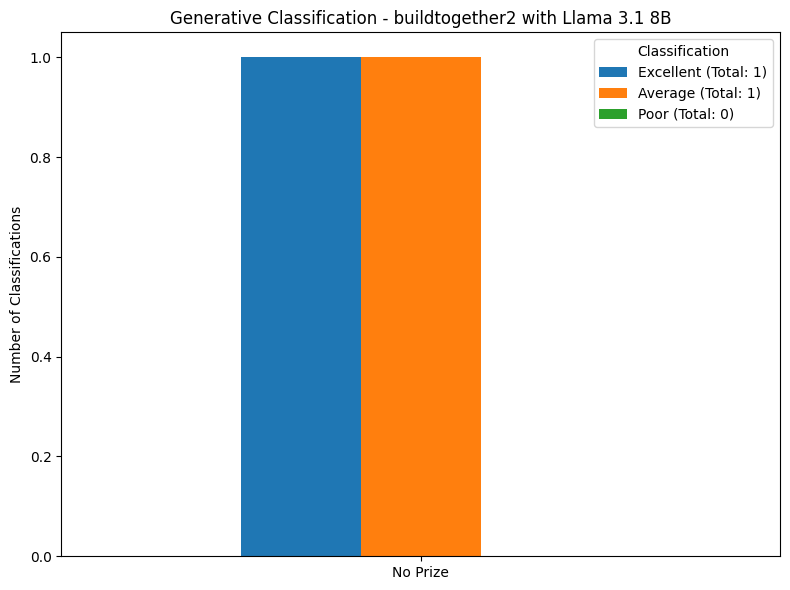


=== Discriminative Classification Classification by Prize Category ===
disc_classification  Excellent  Average  Poor
winner_categories                            
No Prize                     2        0     0 



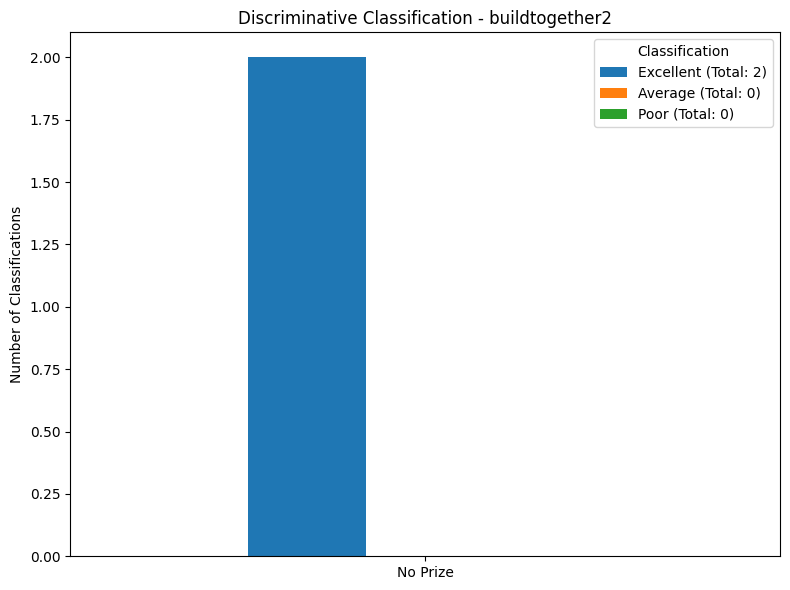

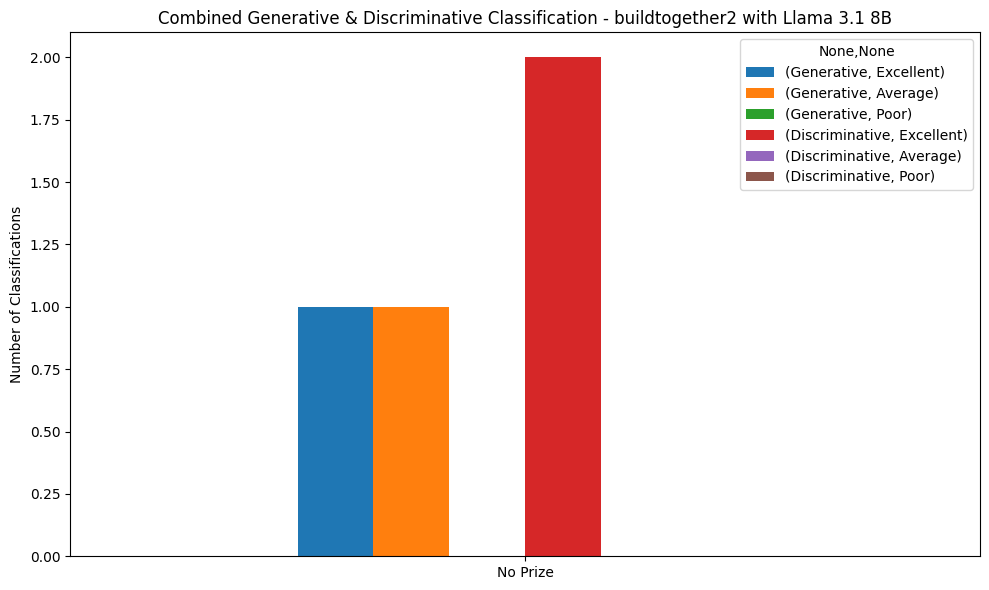

In [ ]:
contest_name = "buildtogether2"
model_name = "Llama 3.1 8B"
# model_name = "DeepSeek R1 Distill Qwen 8B"




plotter = ContestSummaryPlotter(
    csv_path="/content/buildtogether2_evaluation_19_03.csv",
    # csv_path="/content/drive/MyDrive/Master_Thesis/Final Evaluation/buildtogether2_18_03.csv",
    # csv_path=os.path.join("/content", f"evaluation_{contest_name}_17_3.csv"),
    contest_name=contest_name,
    model_name=model_name
)

# Generate summary and plots
plotter.generate_summary_and_plot()